In [1]:
import VariationalBayes as vb
import VariationalBayes.ExponentialFamilies as ef

import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import Objective, unpack_csr_matrix, get_sparse_hessian

import matplotlib.pyplot as plt
%matplotlib inline

import autograd
import autograd.numpy as np

import copy
from scipy import optimize

import os
import json

import time

import pickle


In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.

analysis_name = 'simulated_data_small'
#analysis_name = 'criteo_subsampled'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')

pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)

pkl_file = open(pickle_output_filename, 'rb')
vb_results = pickle.load(pkl_file)


In [51]:
json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
y_g_vec, y_vec, x_mat, glmm_par, prior_par = logit_glmm.load_json_data(json_filename)

K = x_mat.shape[1]
NG = np.max(y_g_vec) + 1

# Define moment parameters
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)
glmm_par.set_free(vb_results['glmm_par_free'])
model = logit_glmm.LogisticGLMM(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, vb_results['num_gh_points'])
objective = Objective(model.glmm_par, model.get_kl)
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
moment_vec = moment_wrapper.get_moment_vector(vb_results['glmm_par_free'])

print(vb_results.keys())

dict_keys(['tau_prior_beta', 'beta_prior_info', 'NG', 'mu_prior_info', 'mu_prior_mean', 'y_group', 'beta_prior_mean', 'x', 'N', 'K', 'y', 'tau_prior_alpha'])
dict_keys(['run_name', 'glmm_par_free', 'num_gh_points', 'glmm_par_dictval', 'log_prior_hess', 'moment_jac', 'inverse_time', 'sparse_vector_hess_packed', 'elbo_hess_packed', 'vb_prior_sens', 'cg_row_time', 'vb_time', 'num_cg_iterations', 'lrvb_cov', 'glmm_par_vector', 'hess_time', 'elbo_inv_moment_jac'])


In [23]:
glmm_par_opt = copy.deepcopy(glmm_par)
def tr_optimize(trust_init, prior_par, gtol=1e-6, maxiter=500):
    model.prior_par.set_vector(prior_par.get_vector())
    objective.logger.initialize()
    objective.logger.print_every = 5
    vb_opt = optimize.minimize(
        lambda par: objective.fun_free(par, verbose=True),
        x0=trust_init,
        method='trust-ncg',
        jac=objective.fun_free_grad,
        hessp=objective.fun_free_hvp,
        tol=1e-6, options={'maxiter': maxiter, 'disp': True, 'gtol': gtol })
    return vb_opt.x


In [56]:

epsilon_list = np.linspace(0.0, 5.0, 10)
moment_vec_list = []

glmm_opt_pert = vb_results['glmm_par_free']
vb_refit_time = time.time()
for epsilon in epsilon_list:
    print('Epsilon: ', epsilon)
    prior_par_pert = copy.deepcopy(prior_par)
    prior_par_pert['mu_prior_info'].set(prior_par['mu_prior_info'].get() + epsilon)

    glmm_opt_pert = tr_optimize(trust_init=glmm_opt_pert, prior_par=prior_par_pert)
    moment_vec_list.append(moment_wrapper.get_moment_vector(glmm_opt_pert))
    
vb_refit_time = time.time() - vb_refit_time

Epsilon:  0.0
Iter  0  value:  69.4078730719
	x_diff:  inf
         Current function value: 69.407873
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Epsilon:  0.555555555556
Iter  0  value:  72.9851745909
	x_diff:  inf
Iter  5  value:  72.7588782322
	x_diff:  0.0825534212171
Optimization terminated successfully.
         Current function value: 72.755513
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
         Hessian evaluations: 0
Epsilon:  1.11111111111
Iter  0  value:  75.9006055697
	x_diff:  inf
Iter  5  value:  75.7390720243
	x_diff:  0.14739051546
Optimization terminated successfully.
         Current function value: 75.737569
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
         Hessian evaluations: 0
Epsilon:  1.66666666667
Iter  0  value:  78.5712722947
	x_diff:  inf
Iter  5  value:  78.4461914112
	x_diff:  0.076044

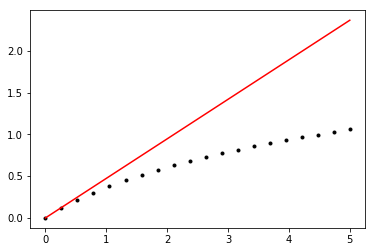

In [54]:
prior_indices = copy.deepcopy(prior_par)
prior_indices.set_vector(np.arange(prior_indices.vector_size()))
mu_info_col = prior_indices['mu_prior_info'].get()[0]

pred_sens_vec = vb_results['vb_prior_sens'][:, mu_info_col]

moment_wrapper.moment_par.set_vector(pred_sens_vec)
mu_pred_sens = moment_wrapper.moment_par['e_mu'].get()[0]

moment_wrapper.moment_par.set_vector(moment_vec)
e_mu_base = moment_wrapper.moment_par['e_mu'].get()[0]

def GetEMu(moment_vec):
    moment_wrapper.moment_par.set_vector(moment_vec)
    return np.squeeze(moment_wrapper.moment_par['e_mu'].get())
    
e_mu_list = [ GetEMu(moment_vec) for moment_vec in moment_vec_list ]

plt.plot(epsilon_list, e_mu_list - e_mu_base, 'k.')
plt.plot(epsilon_list, epsilon_list * mu_pred_sens, 'r')

print(vb_refit_time)